# Advance Topics in Machine Learning, 2023/24
# Natural Language Processing -- Group Assignment

# **Group 5**

**Daniil Terekhin**

**Baris Aksakal**

**Riccardo Giacometti**

**Timur Taepov**

This notebook is the concatenation of three different notebooks that each implemented a required part of the assignment. Thus, the notebook is divided into three main parts, namely, analysis (Investigate dataset), training (Train and evaluate models) and bot (Add voice interactivity and Potential extensions). We have chosen to investigate and build our final bot on SQuAD2.0 dataset. Our final goal was to build a question answering game, utilizing a transformer bot and speach-to-text and text-to-speach modules.

**Analysis**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import json
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from transformers import BertTokenizer, BertForQuestionAnswering, AdamW
from transformers import get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import numpy as np
import random
import time
from transformers import BertTokenizerFast

import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

# Load and prepare the SQuAD dataset
file_path = '/content/drive/MyDrive/USI/train-v2.0.json'

# Load JSON file
with open(file_path, 'r') as file:
    squad_data = json.load(file)

def parse_squad_data(squad_data):
    data = []
    for article in squad_data['data']:
        title = article['title']
        for paragraph in article['paragraphs']:
            context = paragraph['context']
            for qa in paragraph['qas']:
                question = qa['question']
                id = qa['id']
                is_impossible = qa.get('is_impossible', False)
                if not is_impossible:
                    for answer in qa['answers']:
                        data.append({
                            'title': title,
                            'id': id,
                            'context': context,
                            'question': question,
                            'answer': answer['text'],
                            'answer_start': answer['answer_start']
                        })
                else:
                    data.append({
                        'title': title,
                        'id': id,
                        'context': context,
                        'question': question,
                        'answer': None,
                        'answer_start': None
                    })
    return data



df = pd.DataFrame(parse_squad_data(squad_data))
print(df.head(20))

def calculate_answer_end(row):
    if row['answer'] is not None:
        return row['answer_start'] + len(row['answer'])
    return None

df['answer_end'] = df.apply(calculate_answer_end, axis=1)

train_df, val_df = train_test_split(df, test_size=0.1)

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

# Print column names and unique values
for column in df.columns:
    print(f"Column: {column}")
    print(f"Unique Values:\n{df[column].unique()}\n")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


      title                        id  \
0   Beyoncé  56be85543aeaaa14008c9063   
1   Beyoncé  56be85543aeaaa14008c9065   
2   Beyoncé  56be85543aeaaa14008c9066   
3   Beyoncé  56bf6b0f3aeaaa14008c9601   
4   Beyoncé  56bf6b0f3aeaaa14008c9602   
5   Beyoncé  56bf6b0f3aeaaa14008c9603   
6   Beyoncé  56bf6b0f3aeaaa14008c9604   
7   Beyoncé  56bf6b0f3aeaaa14008c9605   
8   Beyoncé  56d43c5f2ccc5a1400d830a9   
9   Beyoncé  56d43c5f2ccc5a1400d830aa   
10  Beyoncé  56d43c5f2ccc5a1400d830ab   
11  Beyoncé  56d43c5f2ccc5a1400d830ac   
12  Beyoncé  56d43c5f2ccc5a1400d830ad   
13  Beyoncé  56d43ce42ccc5a1400d830b4   
14  Beyoncé  56d43ce42ccc5a1400d830b5   
15  Beyoncé  56be86cf3aeaaa14008c9076   
16  Beyoncé  56be86cf3aeaaa14008c9078   
17  Beyoncé  56be86cf3aeaaa14008c9079   
18  Beyoncé  56bf6e823aeaaa14008c9627   
19  Beyoncé  56bf6e823aeaaa14008c9629   

                                              context  \
0   Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...   
1   Beyoncé Giselle Know

In [ ]:
df.head()

,title,id,context,question,answer,answer_start,answer_end
0,Beyoncé,56be85543aeaaa14008c9063,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce start becoming popular?,in the late 1990s,269.0,286.0
1,Beyoncé,56be85543aeaaa14008c9065,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What areas did Beyonce compete in when she was...,singing and dancing,207.0,226.0
2,Beyoncé,56be85543aeaaa14008c9066,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce leave Destiny's Child and bec...,2003,526.0,530.0
3,Beyoncé,56bf6b0f3aeaaa14008c9601,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In what city and state did Beyonce grow up?,"Houston, Texas",166.0,180.0
4,Beyoncé,56bf6b0f3aeaaa14008c9602,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In which decade did Beyonce become famous?,late 1990s,276.0,286.0


### Distribution of context length

We will calculate the length of each context and visualize its distribution

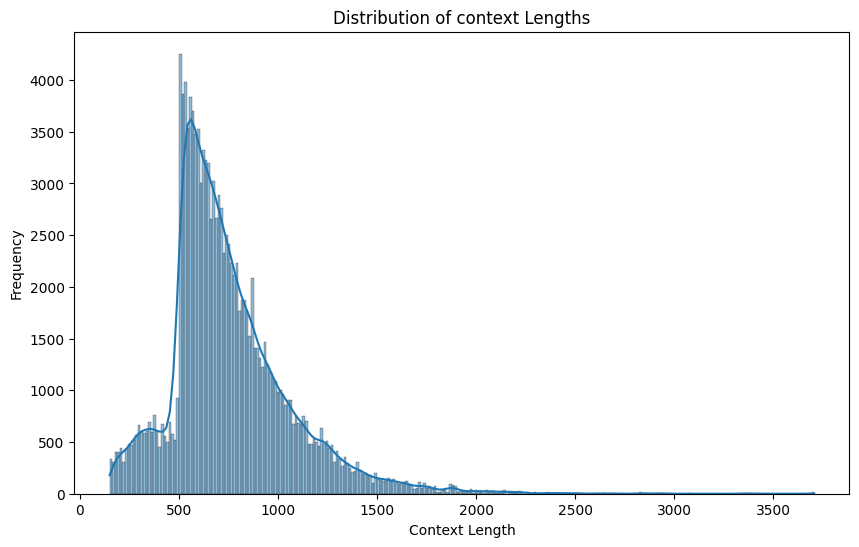

In [ ]:
df['context_length'] = df['context'].apply(len)

# Plot distribution of context lengths
plt.figure(figsize=(10, 6))
sns.histplot(df['context_length'], kde=True)
plt.title('Distribution of context Lengths')
plt.xlabel('Context Length')
plt.ylabel('Frequency')
plt.show()

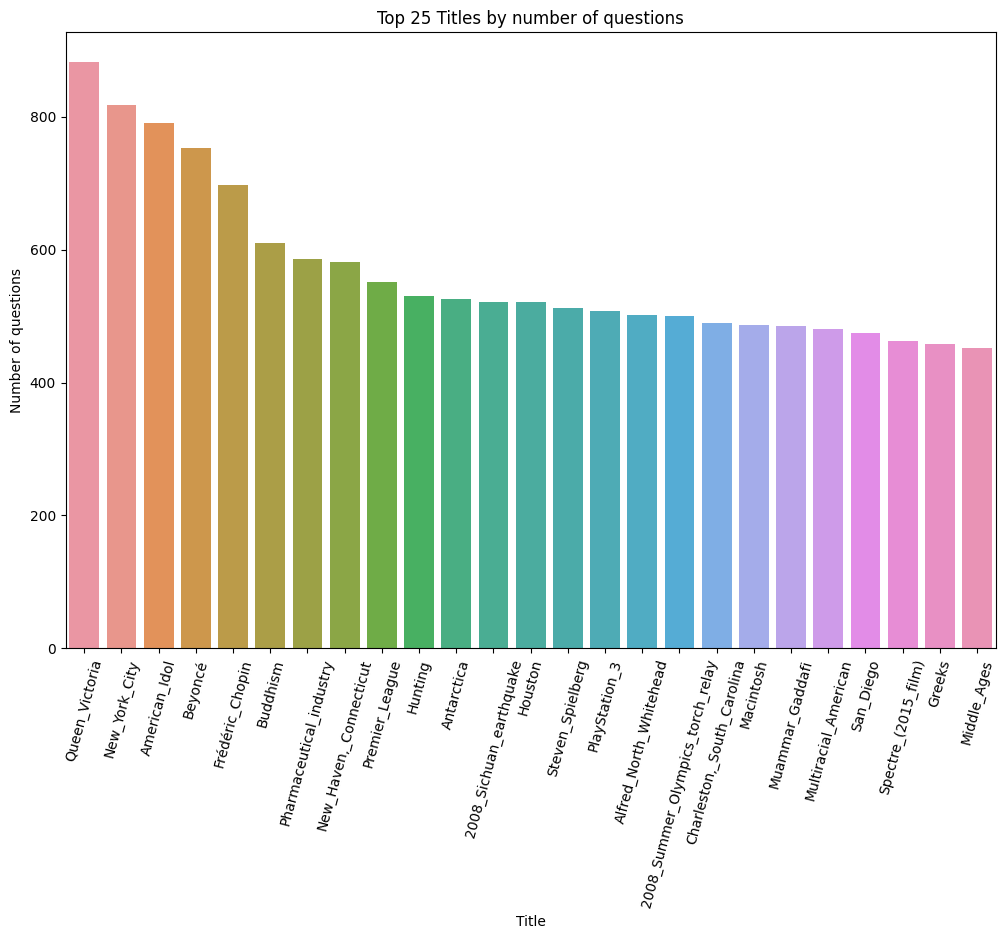

In [ ]:
title_counts = df.groupby('title').size()

top_n = 25
top_titles = title_counts.nlargest(top_n)
plt.figure(figsize=(12, 8))
sns.barplot(x=top_titles.index, y=top_titles.values)
plt.xticks(rotation=75)
plt.xlabel('Title')
plt.ylabel('Number of questions')
plt.title(f'Top {top_n} Titles by number of questions')
plt.show()

In [ ]:
df['question_length'] = df['question'].apply(lambda x: len(x.split()))
df['answer_length'] = df['answer'].apply(lambda x: len(str(x).split()))

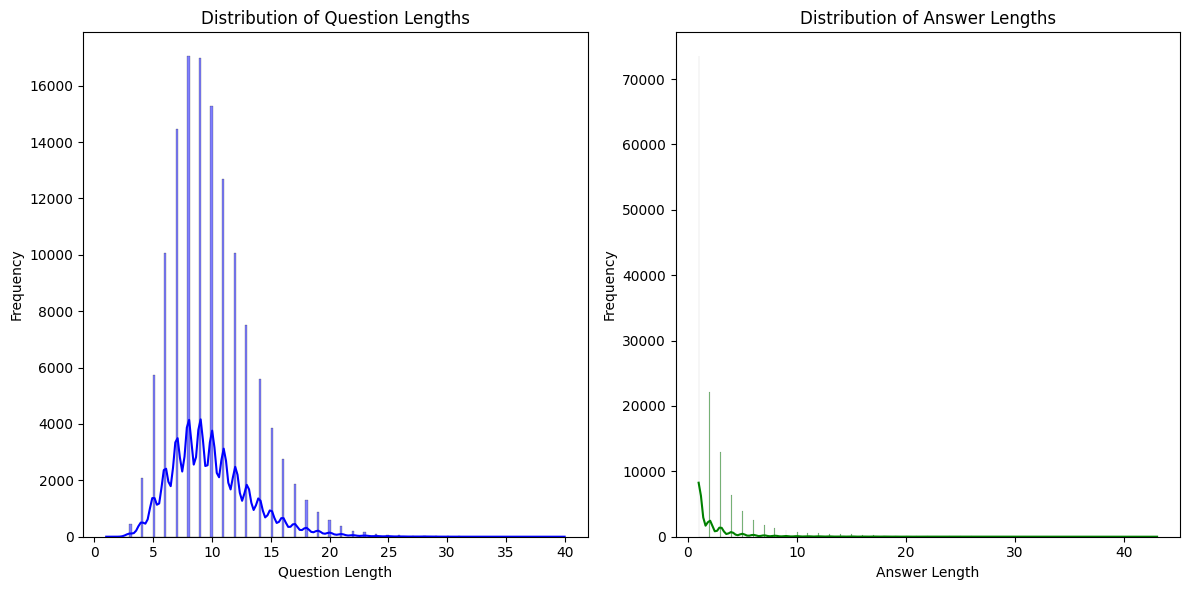

In [ ]:
# Set the size of the plot
plt.figure(figsize=(12, 6))

# Plotting distribution of question lengths
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
sns.histplot(df['question_length'], kde=True, color='blue')
plt.title('Distribution of Question Lengths')
plt.xlabel('Question Length')
plt.ylabel('Frequency')

# Plotting distribution of answer lengths
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
sns.histplot(df['answer_length'], kde=True, color='green')
plt.title('Distribution of Answer Lengths')
plt.xlabel('Answer Length')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


## Vocabulary Size


In [ ]:
def count_vocab(texts):
    word_set = set()
    for text in texts:
        words = text.split()
        word_set.update(words)
    return len(word_set)

# Calculate total vocabulary size across all contexts
total_vocab_size = count_vocab(df['context'])

print("Total vocabulary size across all context:", total_vocab_size)


Total vocabulary size across all context: 185864


### Visualizing Vocabulary as Word Cloud

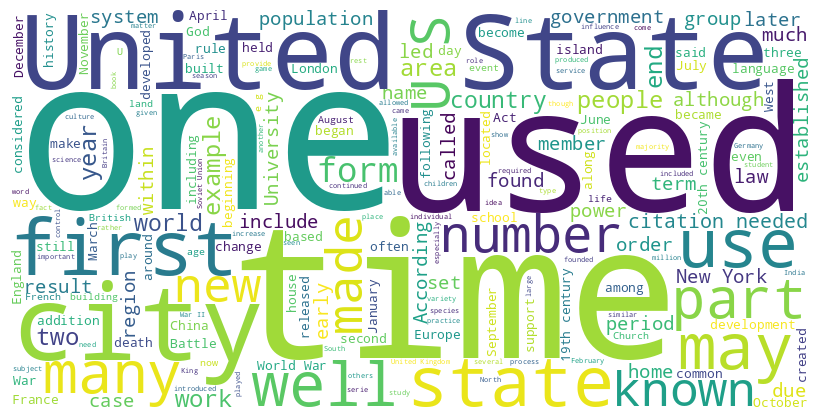

In [ ]:
from wordcloud import WordCloud

# Join all text in 'context' for word cloud
all_text = ' '.join(df['context'])

# Generate word cloud
wordcloud = WordCloud(width = 800, height = 400, background_color ='white').generate(all_text)

# Display the WordCloud
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()


### Counting Unique Documents

In [ ]:
# Count the number of unique documents
unique_documents = df['context'].nunique()

print("Number of unique pages:", unique_documents)


Number of unique pages: 19029


In [ ]:
df.head(4)

,title,id,context,question,answer,answer_start,answer_end,context_length,unique_words,tokenized_context
0,Beyoncé,56be85543aeaaa14008c9063,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce start becoming popular?,in the late 1990s,269.0,286.0,694,89,"[beyoncé, giselle, knowles-carter, (, /biːˈjɒn..."
1,Beyoncé,56be85543aeaaa14008c9065,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What areas did Beyonce compete in when she was...,singing and dancing,207.0,226.0,694,89,"[beyoncé, giselle, knowles-carter, (, /biːˈjɒn..."
2,Beyoncé,56be85543aeaaa14008c9066,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce leave Destiny's Child and bec...,2003,526.0,530.0,694,89,"[beyoncé, giselle, knowles-carter, (, /biːˈjɒn..."
3,Beyoncé,56bf6b0f3aeaaa14008c9601,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In what city and state did Beyonce grow up?,"Houston, Texas",166.0,180.0,694,89,"[beyoncé, giselle, knowles-carter, (, /biːˈjɒn..."


In [ ]:
# Display unique document titles
unique_titles = df['title'].unique()
print("number of unique titles",len(unique_titles))
print()
print("Examples of first 50 titles")
print(unique_titles[:50])


number of unique titles 442

Examples of first 50 titles
['Beyoncé' 'Frédéric_Chopin'
 'Sino-Tibetan_relations_during_the_Ming_dynasty' 'IPod'
 'The_Legend_of_Zelda:_Twilight_Princess' 'Spectre_(2015_film)'
 '2008_Sichuan_earthquake' 'New_York_City' 'To_Kill_a_Mockingbird'
 'Solar_energy' 'Kanye_West' 'Buddhism' 'American_Idol' 'Dog'
 '2008_Summer_Olympics_torch_relay' 'Genome' 'Comprehensive_school'
 'Republic_of_the_Congo' 'Prime_minister' 'Institute_of_technology'
 'Wayback_Machine' 'Dutch_Republic' 'Symbiosis' 'Canadian_Armed_Forces'
 'Cardinal_(Catholicism)' 'Iranian_languages' 'Lighting'
 'Separation_of_powers_under_the_United_States_Constitution'
 'Architecture' 'Human_Development_Index' 'Southern_Europe'
 'BBC_Television' 'Arnold_Schwarzenegger' 'Plymouth' 'Heresy'
 'Warsaw_Pact' 'Materialism' 'Christian' 'Sony_Music_Entertainment'
 'Oklahoma_City' 'Hunter-gatherer' 'United_Nations_Population_Fund'
 'Russian_Soviet_Federative_Socialist_Republic' 'Alexander_Graham_Bell'
 'Pub' '

### Train a Word2Vec Model

In [ ]:
from gensim.models import Word2Vec
import gensim
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

# Preprocess and tokenize the documents
df['tokenized_context'] = df['context'].apply(lambda x: word_tokenize(x.lower()))

# Train the Word2Vec model
model = Word2Vec(sentences=df['tokenized_context'], vector_size=100, window=5, min_count=1, workers=4)

# Save the model
model.save("word2vec.model")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Investigate the Properties

In [ ]:
model = Word2Vec.load("word2vec.model")

# Explore word similarities
print(model.wv.most_similar('beyoncé', topn=5))

# Explore word analogies
print(model.wv.most_similar(positive=['king', 'woman'], negative=['man'], topn=1))


[('madonna', 0.6508049368858337), ('destiny', 0.6000442504882812), ('mendes', 0.5956117510795593), ('spielberg', 0.5752765536308289), ('schwarzenegger', 0.5743563771247864)]
[('whigs', 0.5990692973136902)]


### Index the Documents for Keyword Search

In [ ]:
from collections import defaultdict

# Create an inverted index
inverted_index = defaultdict(list)

for index, row in df.iterrows():
    for word in set(row['tokenized_context']):
        inverted_index[word].append(row['id'])

def search(keyword):
    return inverted_index.get(keyword.lower(), [])

print(search('beyoncé'))

['56be85543aeaaa14008c9063', '56be85543aeaaa14008c9065', '56be85543aeaaa14008c9066', '56bf6b0f3aeaaa14008c9601', '56bf6b0f3aeaaa14008c9602', '56bf6b0f3aeaaa14008c9603', '56bf6b0f3aeaaa14008c9604', '56bf6b0f3aeaaa14008c9605', '56d43c5f2ccc5a1400d830a9', '56d43c5f2ccc5a1400d830aa', '56d43c5f2ccc5a1400d830ab', '56d43c5f2ccc5a1400d830ac', '56d43c5f2ccc5a1400d830ad', '56d43ce42ccc5a1400d830b4', '56d43ce42ccc5a1400d830b5', '56be86cf3aeaaa14008c9076', '56be86cf3aeaaa14008c9078', '56be86cf3aeaaa14008c9079', '56bf6e823aeaaa14008c9627', '56bf6e823aeaaa14008c9629', '56bf6e823aeaaa14008c962a', '56bf6e823aeaaa14008c962b', '56d43da72ccc5a1400d830bd', '56d43da72ccc5a1400d830be', '56d43da72ccc5a1400d830bf', '56d43da72ccc5a1400d830c0', '56d43da72ccc5a1400d830c1', '56be88473aeaaa14008c9080', '56be88473aeaaa14008c9083', '56be88473aeaaa14008c9084', '56bf725c3aeaaa14008c9643', '56bf725c3aeaaa14008c9644', '56bf725c3aeaaa14008c9645', '56bf725c3aeaaa14008c9646', '56bf725c3aeaaa14008c9647', '56d43f7e2ccc5a1400

**Training:** We have chosen to investigate three different models on the dataset. First, we chose to fine-tune a pre-trained transformer (bert-case-uncased) on the squad dataset. Like most traditional models and in line with our dataset, our model takes as input the concatenation of a question and a context that contains the answer to that question. It then outputs the indices that are then used to extract the predicted answer in that context. While not exactly shown in this notebook, we decided on its hyperparameters via trial and error from the training plots. Secondly, from huggingface, we tested a more advanced bert pre-trained model that was already fine-tuned on this exact task and dataset. For uniformity, when evaluating these models, we kept the testing process the same while changing the tokenizers etc. as necessary. Lastly, we tested a well-known LLM (gpt-2) on this task but without access to a context, without any prior training, and on mostly unseen data. Our goal was to evaluate the adaptability (or lack thereof) of gpt-2 on such a difficult task (question given, no context given, no fine-tuning) where it had to reference its pre-training data to predict an answer. Leveraging the prompt understanding capabilities of the GPT models we modified the task as follows. We modified the evaluation questions into the following format -> ("Question:" + question_string + "Answer:" ). Indicating during the prompt that we were expecting the next tokens to be the answer to the given question. After plotting the evaluation metrics of the model we fine-tuned ourselves, we evaluated "exact match" and F1 scores for all the models on a test set. We observed that the pre-trained model by huggingface was the best performing with our model getting comparable results. While the gpt-2 model failed to adapt to such a difficult task. Based on our results we decided to use the model by huggingface for our bot.

In [ ]:
from google.colab import drive
import pandas as pd
import json
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from transformers import BertTokenizer, BertForQuestionAnswering, AdamW
from transformers import get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import numpy as np
import random
import time
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from nltk.tokenize import word_tokenize
import string
import gensim.downloader as api
import gc
from transformers import GPT2Tokenizer, GPT2LMHeadModel
nltk.download('punkt')
word2vec = api.load("word2vec-google-news-300")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load and prepare the SQuAD dataset
file_path = '/content/drive/MyDrive/analytics/train-v2.0.json'

# Load JSON file
with open(file_path, 'r') as file:
    squad_data = json.load(file)

# Parse SQuAD data
def parse_squad_data(squad_data):
    data = []
    for article in squad_data['data']:
        title = article['title']
        for paragraph in article['paragraphs']:
            context = paragraph['context']
            for qa in paragraph['qas']:
                question = qa['question']
                id = qa['id']
                is_impossible = qa.get('is_impossible', False)
                if not is_impossible:
                    for answer in qa['answers']:
                        data.append({
                            'title': title,
                            'id': id,
                            'context': context,
                            'question': question,
                            'answer': answer['text'],
                            'answer_start': answer['answer_start']
                        })
                else:
                    data.append({
                        'title': title,
                        'id': id,
                        'context': context,
                        'question': question,
                        'answer': None,
                        'answer_start': None
                    })
    return data

def calculate_answer_end(row):
    if row['answer'] is not None:
        return row['answer_start'] + len(row['answer'])
    return None

df = pd.DataFrame(parse_squad_data(squad_data))
df = df[df['answer'].notna() & (df['answer'] != '')]
df['answer_end'] = df.apply(calculate_answer_end, axis=1)

train_size = 0.8
validation_size = 0.1
test_size = 0.1

# Ensure the sizes sum up to 1
assert train_size + validation_size + test_size == 1
train_df, temp_df = train_test_split(df, test_size=(validation_size + test_size), random_state=42)

val_size_adjusted = validation_size / (validation_size + test_size)  # Adjust validation size for the second split
val_df, test_df = train_test_split(temp_df, test_size=test_size/(validation_size + test_size), random_state=42)

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def encode_data(tokenizer, data):
    encoded_dicts = []
    for index, row in tqdm(data.iterrows(), total=data.shape[0], desc="Encoding"):
        encoded_dict = tokenizer.encode_plus(
            row['question'], row['context'],
            max_length=384,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=True
        )

        # Handle cases with no answer
        if row['answer'] is not None:
            answer_tokens = tokenizer.encode(row['answer'], add_special_tokens=False)
            try:
                start_token = encoded_dict['input_ids'].index(answer_tokens[0])
            except ValueError:
                # In case the answer is not found in the context due to truncation
                start_token = 0
            end_token = start_token + len(answer_tokens) - 1
        else:
            start_token = 0
            end_token = 0

        encoded_dicts.append({
            'input_ids': encoded_dict['input_ids'],
            'attention_mask': encoded_dict['attention_mask'],
            'token_type_ids': encoded_dict['token_type_ids'],
            'start_positions': start_token,
            'end_positions': end_token
        })
    return encoded_dicts

encoded_train_data = encode_data(tokenizer, train_df)
encoded_val_data = encode_data(tokenizer, val_df)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Encoding:   1%|          | 820/69456 [00:03<04:24, 259.74it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even i

In [ ]:
# Convert encoded data to tensors
def convert_to_tensors(encoded_data):
    input_ids = torch.tensor([item['input_ids'] for item in encoded_data])
    attention_masks = torch.tensor([item['attention_mask'] for item in encoded_data])
    token_type_ids = torch.tensor([item['token_type_ids'] for item in encoded_data])
    start_positions = torch.tensor([item['start_positions'] for item in encoded_data])
    end_positions = torch.tensor([item['end_positions'] for item in encoded_data])
    return input_ids, attention_masks, token_type_ids, start_positions, end_positions

# Convert training and validation data to tensors
train_input_ids, train_attention_masks, train_token_type_ids, train_start_positions, train_end_positions = convert_to_tensors(encoded_train_data)
val_input_ids, val_attention_masks, val_token_type_ids, val_start_positions, val_end_positions = convert_to_tensors(encoded_val_data)

batch_size = 64
train_data = TensorDataset(train_input_ids, train_attention_masks, train_token_type_ids, train_start_positions, train_end_positions)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_input_ids, val_attention_masks, val_token_type_ids, val_start_positions, val_end_positions)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)


In [ ]:
def exact_match_score(prediction, truth):
    return prediction.strip().lower() == truth.strip().lower()

def normalize_answer(s):
    """Lower text and remove punctuation, articles and extra whitespace."""
    def white_space_fix(text):
        return ' '.join(text.split())
    def remove_punct(text):
        return text.translate(str.maketrans('', '', string.punctuation))
    def lower(text):
        return text.lower()
    return white_space_fix(remove_punct(lower(s)))

def f1_score(prediction, truth):
    prediction_tokens = normalize_answer(prediction).split()
    truth_tokens = normalize_answer(truth).split()
    common_tokens = Counter(prediction_tokens) & Counter(truth_tokens)
    num_same = sum(common_tokens.values())
    if num_same == 0:
        return 0
    precision = 1.0 * num_same / len(prediction_tokens)
    recall = 1.0 * num_same / len(truth_tokens)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1

model = BertForQuestionAnswering.from_pretrained('bert-base-uncased')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

optimizer = AdamW(model.parameters(), lr=3e-5)
epochs = 4
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

train_losses, val_losses = [], []
train_exact_matches, val_exact_matches = [], []
train_f1_scores, val_f1_scores = [], []

for epoch_i in range(epochs):
    print(f'======== Epoch {epoch_i + 1} / {epochs} ========')
    model.train()

    # to store predictions and actual answers for training
    train_predictions, train_actuals = [], []

    for step, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc=f"Training Epoch {epoch_i+1}"):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_attention_mask, b_token_type_ids, b_start_positions, b_end_positions = batch

        model.zero_grad()
        outputs = model(b_input_ids, token_type_ids=b_token_type_ids, attention_mask=b_attention_mask, start_positions=b_start_positions, end_positions=b_end_positions)
        loss = outputs.loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        train_losses.append(loss.item())

        # Store predictions and actual answers for later metric calculation
        start_indices = torch.argmax(outputs.start_logits, dim=1)
        end_indices = torch.argmax(outputs.end_logits, dim=1)
        for i in range(start_indices.size(0)):
            span = tokenizer.decode(b_input_ids[i, start_indices[i]:end_indices[i]+1])
            actual = tokenizer.decode(b_input_ids[i, b_start_positions[i]:b_end_positions[i]+1])
            train_predictions.append(span)
            train_actuals.append(actual)

    # Calculate metrics for training data after the epoch
    total_train_exact_match = sum(exact_match_score(pred, act) for pred, act in zip(train_predictions, train_actuals))
    total_train_f1 = sum(f1_score(pred, act) for pred, act in zip(train_predictions, train_actuals))

    train_exact_matches.append(total_train_exact_match / len(train_dataloader.dataset))
    train_f1_scores.append(total_train_f1 / len(train_dataloader.dataset))

    # Validation
    model.eval()

    # to store predictions and actual answers for validation
    val_predictions, val_actuals = [], []

    for step, batch in tqdm(enumerate(val_dataloader), total=len(val_dataloader), desc="Validating"):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_attention_mask, b_token_type_ids, b_start_positions, b_end_positions = batch

        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=b_token_type_ids, attention_mask=b_attention_mask, start_positions=b_start_positions, end_positions=b_end_positions)
            loss = outputs.loss
            val_losses.append(loss.item())

            # Store predictions and actual answers for later metric calculation
            start_indices = torch.argmax(outputs.start_logits, dim=1)
            end_indices = torch.argmax(outputs.end_logits, dim=1)
            for i in range(start_indices.size(0)):
                span = tokenizer.decode(b_input_ids[i, start_indices[i]:end_indices[i]+1])
                actual = tokenizer.decode(b_input_ids[i, b_start_positions[i]:b_end_positions[i]+1])
                val_predictions.append(span)
                val_actuals.append(actual)

    # Calculate metrics for validation data after the epoch
    total_val_exact_match = sum(exact_match_score(pred, act) for pred, act in zip(val_predictions, val_actuals))
    total_val_f1 = sum(f1_score(pred, act) for pred, act in zip(val_predictions, val_actuals))

    val_exact_matches.append(total_val_exact_match / len(val_dataloader.dataset))
    val_f1_scores.append(total_val_f1 / len(val_dataloader.dataset))

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


======== Epoch 1 / 4 ========


Validating: 100%|██████████| 136/136 [00:43<00:00,  3.11it/s]


======== Epoch 2 / 4 ========


Validating: 100%|██████████| 136/136 [00:43<00:00,  3.10it/s]


======== Epoch 3 / 4 ========


Validating: 100%|██████████| 136/136 [00:43<00:00,  3.11it/s]


======== Epoch 4 / 4 ========


Validating: 100%|██████████| 136/136 [00:43<00:00,  3.10it/s]


<function matplotlib.pyplot.legend(*args, **kwargs)>

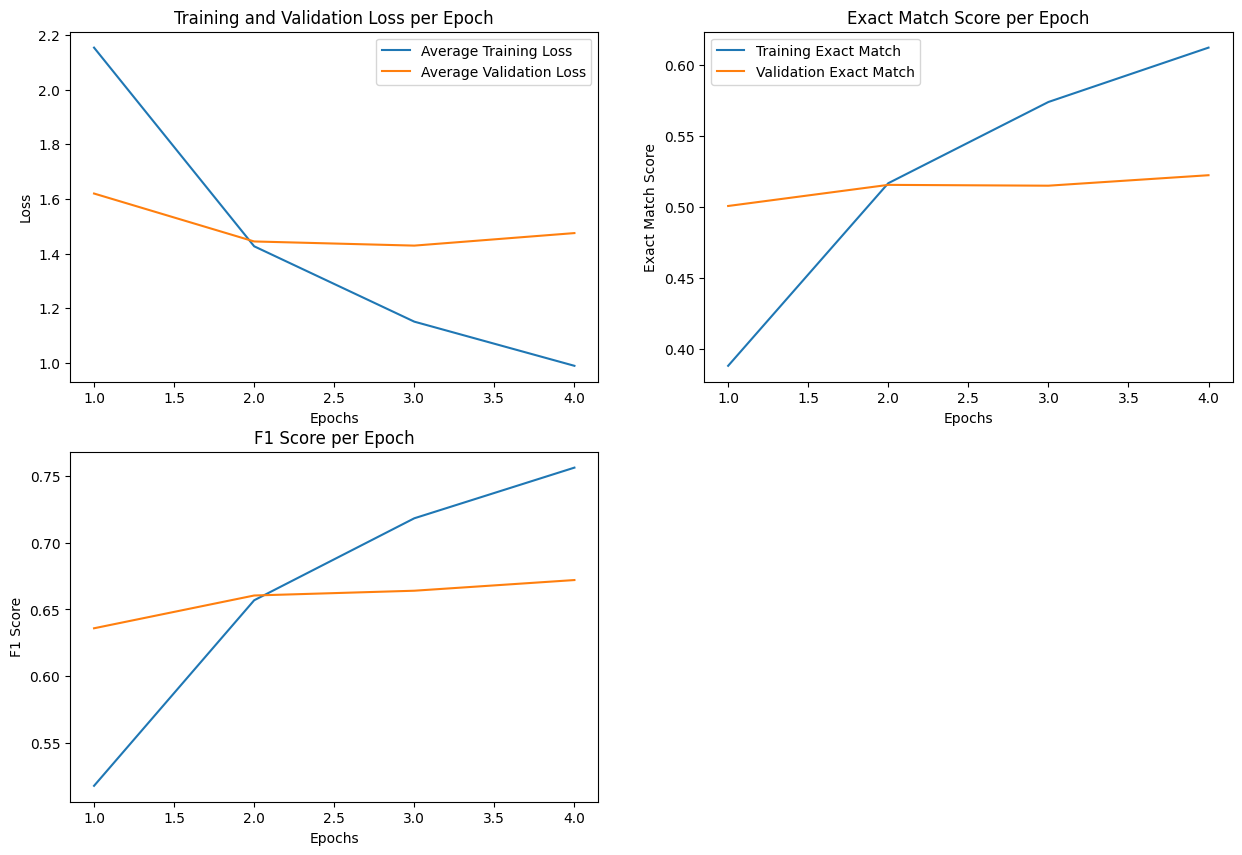

In [ ]:
num_epochs = 4
batch_per_epoch_train = len(train_losses) // num_epochs
batch_per_epoch_val = len(val_losses) // num_epochs

avg_train_losses = [sum(train_losses[i:i+batch_per_epoch_train])/batch_per_epoch_train for i in range(0, len(train_losses), batch_per_epoch_train)]
avg_val_losses = [sum(val_losses[i:i+batch_per_epoch_val])/batch_per_epoch_val for i in range(0, len(val_losses), batch_per_epoch_val)]

epochs = list(range(1, num_epochs + 1))

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(epochs, avg_train_losses, label='Average Training Loss')
plt.plot(epochs, avg_val_losses, label='Average Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()

# Plotting exact matches
plt.subplot(2, 2, 2)
plt.plot(epochs, train_exact_matches, label='Training Exact Match')
plt.plot(epochs, val_exact_matches, label='Validation Exact Match')
plt.xlabel('Epochs')
plt.ylabel('Exact Match Score')
plt.title('Exact Match Score per Epoch')
plt.legend()

# Plotting F1 scores
plt.subplot(2, 2, 3)
plt.plot(epochs, train_f1_scores, label='Training F1 Score')
plt.plot(epochs, val_f1_scores, label='Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('F1 Score per Epoch')
plt.legend

In [ ]:
encoded_test_data = encode_data(tokenizer, test_df)
test_input_ids, test_attention_masks, test_token_type_ids, test_start_positions, test_end_positions = convert_to_tensors(encoded_test_data)
test_data = TensorDataset(test_input_ids, test_attention_masks, test_token_type_ids, test_start_positions, test_end_positions)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

model.eval()
test_predictions, test_actuals = [], []

for step, batch in tqdm(enumerate(test_dataloader), total=len(test_dataloader), desc="Testing"):
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_attention_mask, b_token_type_ids, b_start_positions, b_end_positions = batch

    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=b_token_type_ids, attention_mask=b_attention_mask, start_positions=b_start_positions, end_positions=b_end_positions)

        # Store predictions and actual answers for later metric calculation
        start_indices = torch.argmax(outputs.start_logits, dim=1)
        end_indices = torch.argmax(outputs.end_logits, dim=1)
        for i in range(start_indices.size(0)):
            span = tokenizer.decode(b_input_ids[i, start_indices[i]:end_indices[i]+1])
            actual = tokenizer.decode(b_input_ids[i, b_start_positions[i]:b_end_positions[i]+1])
            test_predictions.append(span)
            test_actuals.append(actual)

# Calculate metrics for testidation data after the epoch
total_test_exact_match = sum(exact_match_score(pred, act) for pred, act in zip(test_predictions, test_actuals))
total_test_f1 = sum(f1_score(pred, act) for pred, act in zip(test_predictions, test_actuals))

test_exact_matches = (total_test_exact_match / len(test_dataloader.dataset))
test_f1_scores = (total_test_f1 / len(test_dataloader.dataset))

print(test_exact_matches)
print(test_f1_scores)

Encoding:   1%|          | 85/8683 [00:00<00:30, 282.86it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Encoding:  13%|█▎        | 1089/8683 [00:03<00:27, 273.06it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some 

0.5204422434642405
0.669438178628271


In [ ]:
model_save_path = '/content/drive/MyDrive/model123/model_entire.pth'
checkpoint_save_path = '/content/drive/MyDrive/model123/model_checkpoint.pth'

# Save the model
torch.save(model, model_save_path)

checkpoint = {
    'epoch': epochs,
    'optimizer_state_dict': optimizer.state_dict()
}

torch.save(checkpoint, checkpoint_save_path)

In [ ]:
# Filter out rows where the 'answer' column is empty, None, or NaN
filtered_val_df = val_df[val_df['answer'].notna() & (val_df['answer'] != '')]

# Now randomly sample 5 instances from the filtered DataFrame
samples = filtered_val_df.sample(5)

model.eval()

for index, row in samples.iterrows():
    print(f"Question: {row['question']}\nContext: {row['context']}\nActual Answer: {row['answer']}")

    inputs = tokenizer.encode_plus(row['question'], row['context'], return_tensors='pt')

    inputs = {k: v.to(device) for k, v in inputs.items()}

    outputs = model(**inputs)
    answer_start = torch.argmax(outputs.start_logits)
    answer_end = torch.argmax(outputs.end_logits) + 1
    prediction = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(inputs['input_ids'][0][answer_start:answer_end]))

    print(f"Predicted Answer: {prediction}\n\n")

Question: What did Sarah Forsyth provide as evidence to her unfair termination and job duties?
Context: In October 2004, Sarah Forsyth claimed that she had been dismissed unfairly by Eton College and had been bullied by senior staff. She also claimed she was instructed to do some of Prince Harry's coursework to enable him to pass AS Art. As evidence, Forsyth provided secretly recorded conversations with both Prince Harry and her Head of Department, Ian Burke. An employment tribunal in July 2005 found that she had been unfairly dismissed and criticised Burke for bullying her and for repeatedly changing his story. It also criticised the school for failing to produce its capability procedures and criticised the Head Master for not reviewing the case independently.
Actual Answer: secretly recorded conversations with both Prince Harry and her Head of Department, Ian Burke
Predicted Answer: secretly recorded conversations


Question: How many people were present at the speech that Truman mad

In [ ]:
def text_to_vec(text):
    words = word_tokenize(text.lower())
    words = [word for word in words if word in word2vec.key_to_index]
    return np.mean(word2vec[words], axis=0) if words else np.zeros(word2vec.vector_size)

def find_most_relevant_context(df, user_input):
    user_vec = text_to_vec(user_input)
    similarity_scores = []

    for context in df['context'].unique():
        context_vec = text_to_vec(context)
        similarity = cosine_similarity([user_vec], [context_vec])[0][0]
        similarity_scores.append((context, similarity))

    sorted_contexts = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
    return sorted_contexts[0][0] if sorted_contexts else None

def get_answer_to_question(user_question, df, model, tokenizer, device):
    most_relevant_context = find_most_relevant_context(df, user_question)
    combined_input = user_question + " " + most_relevant_context

    encoded_input = tokenizer.encode_plus(
        combined_input,
        max_length=512,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    input_ids = encoded_input['input_ids'].to(device)
    attention_mask = encoded_input['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
    start_logits = outputs.start_logits
    end_logits = outputs.end_logits

    start_index = torch.argmax(start_logits)
    end_index = torch.argmax(end_logits)

    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    answer_tokens = tokens[start_index: end_index + 1]
    answer = tokenizer.convert_tokens_to_string(answer_tokens)

    return answer

user_question = "The USB Power Delivery revision 2.0 specification has been released as part of what?"
answer = get_answer_to_question(user_question, df, model, tokenizer, device)
print(answer)

the usb power delivery


In [ ]:
"""
# Load the entire model
model = torch.load(model_save_path)
model.to(device)

# Load the training checkpoint
checkpoint = torch.load(checkpoint_save_path)
optimizer = AdamW(model.parameters(), lr=3e-5)  # Reinitialize the optimizer
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
"""

"\n# Load the entire model\nmodel = torch.load(model_save_path)\nmodel.to(device) \n\n# Load the training checkpoint\ncheckpoint = torch.load(checkpoint_save_path)\noptimizer = AdamW(model.parameters(), lr=3e-5)  # Reinitialize the optimizer\noptimizer.load_state_dict(checkpoint['optimizer_state_dict'])\n"

In [ ]:
# Empty GPU memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    gc.collect()

# Load pre-trained model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

filtered_test_df = test_df[test_df['answer'].notna() & (test_df['answer'] != '')]

# Convert DataFrame to lists
test_contexts = filtered_test_df['context'].tolist()
test_questions = filtered_test_df['question'].tolist()
test_answers = filtered_test_df['answer'].tolist()

total_exact_match = 0
total_f1 = 0

for context, question, expected_answer in tqdm(zip(test_contexts, test_questions, test_answers), total=len(test_contexts)):
    inputs = tokenizer.encode_plus(
        question,
        context,
        return_tensors='pt',
        max_length=512,
        truncation=True
    )
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
    answer_start_scores, answer_end_scores = outputs.start_logits, outputs.end_logits

    answer_start = torch.argmax(answer_start_scores)
    answer_end = torch.argmax(answer_end_scores) + 1
    answer_tokens = inputs['input_ids'][0, answer_start:answer_end]
    predicted_answer = tokenizer.decode(answer_tokens)

    total_exact_match += exact_match_score(predicted_answer, expected_answer)
    total_f1 += f1_score(predicted_answer, expected_answer)

# Calculate final metrics for the test dataset
final_exact_match_test = total_exact_match / len(test_contexts)
final_f1_score_test = total_f1 / len(test_contexts)


Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 8683/8683 [03:07<00:00, 46.21it/s]


In [ ]:
def generate_answer(question, model, tokenizer, max_length=384):
    # Modify the question format to indicate that an answer is expected
    modified_question = f"Question: {question} Answer:"

    inputs = tokenizer.encode_plus(
        modified_question,
        return_tensors='pt',
        padding='max_length',
        truncation=True,
        max_length=max_length
    )
    inputs = {key: value.to(device) for key, value in inputs.items()}

    # Generate the output sequence
    outputs = model.generate(
        input_ids=inputs['input_ids'],
        attention_mask=inputs['attention_mask'],
        max_length=max_length,
        pad_token_id=tokenizer.eos_token_id  # Use EOS token as pad (expected for pretrained model)
    )
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Extract the answer from the generated text, just get part after the Answer:
    answer = generated_text.split("Answer:")[1].strip()
    return answer

def clear_gpu_memory():
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        gc.collect()

clear_gpu_memory()

model = GPT2LMHeadModel.from_pretrained('gpt2')
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
# Set pad token to EOS token and set padding side to left (expected for pretrained model)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = 'left'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

filtered_test_df = test_df[test_df['answer'].notna() & (test_df['answer'] != '')]

# Convert DataFrame to lists
test_questions = filtered_test_df['question'].tolist()
test_answers = filtered_test_df['answer'].tolist()

total_exact_match = 0
total_f1 = 0

for question, expected_answer in tqdm(zip(test_questions, test_answers), total=len(test_questions)):
    predicted_answer = generate_answer(question, model, tokenizer)

    total_exact_match += exact_match_score(predicted_answer, expected_answer)
    total_f1 += f1_score(predicted_answer, expected_answer)

# Calculate final metrics
llm_exact_match = total_exact_match / len(test_questions)
llm_f1_score = total_f1 / len(test_questions)

  0%|          | 0/8683 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 384, but `max_length` is set to 384. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


In [ ]:
print(f"Fine Tuned Model Exact Match: {test_exact_matches}")
print(f"Fine Tuned Model F1 Score: {test_f1_scores}")

Fine Tuned Model Exact Match: 0.5204422434642405
Fine Tuned Model F1 Score: 0.669438178628271


In [ ]:
print(f"Pretrained Model (SQuAD) Exact Match: {final_exact_match_test}")
print(f"Pretrained Model (SQuAD) F1 Score: {final_f1_score_test}")

Pretrained Model (SQuAD) Exact Match: 0.6813313370954739
Pretrained Model (SQuAD) F1 Score: 0.8562114351104593


In [ ]:
print(f"GPT-2 Zero-shot Exact Match: {llm_exact_match}")
print(f"GPT-2 Zero-shot F1 Score: {llm_f1_score}")

GPT-2 Zero-shot Exact Match: 0.002188183807439825
GPT-2 Zero-shot F1 Score: 0.03831134614299359


**Bot:** Lastly, we proceeded to build our question-answering game bot. Turn by turn, the player and the bot each ask each other a question that should be answered. If the player or the bot answers a question correctly they/it gain/s a point. The first to reach 2 points wins the game.
On the player's turn, the player asks the bot a question using their voice. The bot transcripts that voice file and using the dataset, word2vec and cosine similarity, matches the user's question to a title and presents the user with 5 titles which they confirm is related to the question. Afterward from the dataset, the bot searches for the items containing that title and runs the similarity search on all of the contexts to find the related context for the question. The bot then, using the question and the predicted context, predicts an answer to the question. Also speaking it out as a voice file. Lastly, the user confirms if the question is correct or not. In Bot's turn, the bot randomly samples 5 titles and presents them to the player. The player chooses which title they want to be questioned on. Using that title, the bot, samples a related question and asks it to the user. By recording their voice, the user answers the question. Similarly, after transcribing the recording, the bot (using word2vec, cosine similarity, and a threshold) gives his evaluation of the correctness of the answer. The player then confirms if their answer is correct or not. An example game between the user and the bot is given at the bottom of this notebook. The game is best understood through that example.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip3 install SpeechRecognition pydub gtts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 33.3 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
import pandas as pd
import json
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from transformers import BertTokenizer, BertForQuestionAnswering, AdamW
from transformers import get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import numpy as np
import random
import time
import matplotlib.pyplot as plt
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
import string
import gensim.downloader as api
from sklearn.metrics.pairwise import cosine_similarity
import gc
import speech_recognition as sr
from pydub import AudioSegment
from IPython.display import display, Javascript, Audio
from google.colab import output
from base64 import b64decode
from gtts import gTTS
import os
nltk.download('punkt')

# Load the pre-trained Word2Vec model
word2vec_model = api.load('word2vec-google-news-300')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
file_path = '/content/drive/MyDrive/analytics/train-v2.0.json'

# Load JSON file
with open(file_path, 'r') as file:
    squad_data = json.load(file)

# Parse SQuAD data
def parse_squad_data(squad_data):
    data = []
    for article in squad_data['data']:
        title = article['title']
        for paragraph in article['paragraphs']:
            context = paragraph['context']
            for qa in paragraph['qas']:
                question = qa['question']
                id = qa['id']
                is_impossible = qa.get('is_impossible', False)
                if not is_impossible:
                    for answer in qa['answers']:
                        data.append({
                            'title': title,
                            'id': id,
                            'context': context,
                            'question': question,
                            'answer': answer['text'],
                            'answer_start': answer['answer_start']
                        })
                else:
                    data.append({
                        'title': title,
                        'id': id,
                        'context': context,
                        'question': question,
                        'answer': None,
                        'answer_start': None
                    })
    return data

def calculate_answer_end(row):
    if row['answer'] is not None:
        return row['answer_start'] + len(row['answer'])
    return None

df = pd.DataFrame(parse_squad_data(squad_data))
df = df[df['answer'].notna() & (df['answer'] != '')]
df['answer_end'] = df.apply(calculate_answer_end, axis=1)

tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), ep

In [ ]:
import random
import speech_recognition as sr
from gtts import gTTS
from pydub import AudioSegment
from base64 import b64decode

display(Javascript('''
async function recordAudio(sec) {
    const stream = await navigator.mediaDevices.getUserMedia({audio: true});
    const mediaRecorder = new MediaRecorder(stream);
    let audioChunks = [];

    mediaRecorder.addEventListener("dataavailable", event => {
        audioChunks.push(event.data);
    });

    mediaRecorder.start();

    await new Promise(resolve => setTimeout(resolve, sec * 1000));

    mediaRecorder.stop();

    return new Promise(resolve => {
        mediaRecorder.addEventListener("stop", () => {
            const audioBlob = new Blob(audioChunks);
            const reader = new FileReader();
            reader.readAsDataURL(audioBlob);
            reader.onloadend = () => {
                let base64String = reader.result;
                resolve(base64String.split(',')[1]);
            };
        });
    });
}
'''))


def get_answer_to_question(question, context):
    # Encode the question and context
    inputs = tokenizer.encode_plus(question, context, return_tensors='pt', max_length=512, truncation=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Get model predictions
    with torch.no_grad():
        outputs = model(**inputs)

    # Find the start and end of the answer in the context
    answer_start = torch.argmax(outputs.start_logits)
    answer_end = torch.argmax(outputs.end_logits) + 1

    # Convert tokens to answer string
    answer_tokens = inputs['input_ids'][0, answer_start:answer_end]
    answer = tokenizer.decode(answer_tokens)

    # Convert answer text to speech
    tts = gTTS(answer, lang='en')
    tts.save('answer.mp3')

    # Play the answer
    play_audio('answer.mp3')

    return answer

def play_audio(file_path):
    if os.path.exists(file_path):
        display(Audio(file_path, autoplay=True))
    else:
        print("Audio file not found.")


# Compute average Word2Vec embedding for a text
def get_embedding(text, model):
    words = text.split()
    valid_words = [word for word in words if word in model.key_to_index]
    if valid_words:
        embedding = np.mean([model[word] for word in valid_words], axis=0)
        return embedding
    else:
        return np.zeros(model.vector_size)

def find_most_relevant_context(df, question, model):
    # Find the top matching titles
    question_embedding = get_embedding(question, model)
    titles = df['title'].unique()
    title_embeddings = np.array([get_embedding(title, model) for title in titles])

    similarities = cosine_similarity([question_embedding], title_embeddings)[0]
    top_indices = np.argsort(similarities)[-5:][::-1]

    # Display the top matching titles with numbers and similarity scores
    for i, index in enumerate(top_indices, 1):
        similarity_percentage = round(similarities[index] * 100, 2)  # Convert to percentage
        print(f"{i}. {titles[index]} ({similarity_percentage}%)")

    # User selects the number
    while True:
        try:
            selection = int(input("Bot thinks your title is related to above titles, chose the correct one (1-5): "))
            if 1 <= selection <= 5:
                selected_index = top_indices[selection - 1]
                selected_title = titles[selected_index]
                break
            else:
                print("Invalid number. Please select a number between 1 and 5.")
        except ValueError:
            print("Invalid input. Please enter a number.")

    # Extract all contexts for the selected title
    contexts = df[df['title'] == selected_title]['context'].tolist()

    # Find the most similar context to the question
    context_embeddings = np.array([get_embedding(context, model) for context in contexts])
    context_similarities = cosine_similarity([question_embedding], context_embeddings)[0]
    most_relevant_context_index = np.argmax(context_similarities)

    return contexts[most_relevant_context_index]

# Function to select a random question from the database
def select_random_question(df):
    random_title = random.choice(df['title'].unique())
    random_question = random.choice(df[df['title'] == random_title]['question'].tolist())
    return random_title, random_question

def record(sec=5):
    # Ask for user confirmation before starting the recording
    confirmation = input("Are you ready to record? Type 'yes' to start: ")
    if confirmation.lower() == 'yes':
        print("Recording will start now. Please speak after the prompt.")

        # Start recording
        data = output.eval_js('recordAudio(%d)' % sec)
        # Decode the base64 audio data
        audio = b64decode(data)
        # Save the audio data to a file
        with open('audio.webm', 'wb') as f:
            f.write(audio)

        # Convert WebM to WAV
        webm_audio = AudioSegment.from_file('audio.webm', format="webm")
        webm_audio.export('audio.wav', format="wav")
        print('Recording complete')
    else:
        print("Recording cancelled.")


def text_to_speech(text, lang='en'):
    if not text.strip():
        print("Couldn't find a matching answer.")
        return None
    try:
        tts = gTTS(text, lang=lang)
        tts.save('output.mp3')
        return 'output.mp3'
    except Exception as e:
        print(f"Error in text to speech conversion: {e}")
        return None

def transcribe_audio(audio_file_path):
    recognizer = sr.Recognizer()
    with sr.AudioFile(audio_file_path) as source:
        # Record the audio file into an audio data object
        audio_data = recognizer.record(source)
        try:
            # Transcribe the audio data to text
            text = recognizer.recognize_google(audio_data)
            print(f"Transcribed Text: '{text}'")  # Print the transcribed text
            return text
        except sr.UnknownValueError:
            # Error handling for unrecognized speech
            print("Could not understand the audio.")
            return None
        except sr.RequestError as e:
            # Error handling for API request errors
            print(f"Could not request results from Google Speech Recognition service; {e}")
            return None


def ask_bot_question(df):
    # Bot selects a random title and question
    chosen_title, question = select_random_question(df)

    # Present the question to the user
    print(f"\nBot's turn:\nChosen Title: {chosen_title}\nBot's question: {question}")

    # Record user's answer
    record(5)
    user_answer = transcribe_audio()

    # Verify if user's answer is correct
    correct_answer = get_answer_to_question(question, df[df['title'] == chosen_title]['context'].iloc[0])
    if is_answer_similar(user_answer, correct_answer, word2vec_model):
        print("Correct Answer!")
        return True
    else:
        print(f"Incorrect. The correct answer was: {correct_answer}")
        return False


def user_turn(df, word2vec_model):
    print("\nYour turn: Ask any question.")
    record(5)  # Record user's question
    user_question = transcribe_audio('audio.wav')

    if user_question is None:
        print("Sorry, I couldn't understand your question. Please try again.")
        return False

    # Bot provides an answer
    context = find_most_relevant_context(df, user_question, word2vec_model)
    bot_answer = get_answer_to_question(user_question, context)
    print("Bot's Answer:", bot_answer)

    # Ask user to verify answer
    user_input = input("Was the bot's answer correct? (yes/no): ")
    return user_input.lower() == 'yes'



def bot_turn(df, word2vec_model):
    print("\nBot's turn:")

    # Sample 5 unique titles randomly from the DataFrame
    sampled_titles = random.sample(list(df['title'].unique()), min(5, len(df['title'].unique())))

    print("\nBot Sampled five titles for you, which title do you want to be questioned on (1-5):")
    for i, title in enumerate(sampled_titles, 1):
        print(f"{i}. {title}")

    # User selects a title
    while True:
        try:
            selection = int(input("\nPlease select a title number: "))
            if 1 <= selection <= len(sampled_titles):
                chosen_title = sampled_titles[selection - 1]
                break
            else:
                print("Invalid number. Please select a number from the list.")
        except ValueError:
            print("Invalid input. Please enter a number.")

    # Bot selects a question from the chosen title
    chosen_questions = df[df['title'] == chosen_title]
    chosen_row = chosen_questions.sample()
    question = chosen_row['question'].iloc[0]
    correct_answer = chosen_row['answer'].iloc[0]

    print(f"Chosen title: {chosen_title}")
    print("Bot's question:", question)

    # User answers the question
    record(7)  # Record user's answer
    user_answer = transcribe_audio('audio.wav')

    if user_answer is None:
        print("Sorry, I couldn't understand your answer. Please try again.")
        return False

    # Display the correct answer
    print(f"Bot's question: {question}")
    print(f"Your answer: {user_answer}")
    print(f"Correct answer: {correct_answer}")

    # Calculate cosine similarity
    user_embedding = get_embedding(user_answer, word2vec_model)
    correct_embedding = get_embedding(correct_answer, word2vec_model)
    similarity = cosine_similarity([user_embedding], [correct_embedding])[0][0]
    print(f"Cosine similarity with correct answer: {similarity:.2f}")

    # Bot's preliminary judgment based on the similarity
    threshold = 0.6
    if similarity > threshold:
        print("Bot's opinion: Your answer is likely correct.")
    else:
        print("Bot's opinion: Your answer is likely incorrect.")

    # User provides their final verdict
    user_input = input("Do you think your answer was correct? (yes/no): ")
    return user_input.lower() == 'yes'


def is_answer_similar(user_answer, correct_answer, model):
    user_embedding = get_embedding(user_answer, model)
    correct_embedding = get_embedding(correct_answer, model)

    similarity = cosine_similarity([user_embedding], [correct_embedding])[0][0]
    similarity_percentage = round(similarity * 100, 2)  # Convert to percentage
    print(f"Similarity with correct answer: {similarity_percentage}%")

    threshold = 0.6
    return similarity > threshold


def game_loop(df, word2vec_model):
    user_score, bot_score = 0, 0
    rounds = 0
    while user_score < 2 and bot_score < 2 and rounds < 4:
        if rounds % 2 == 0:  # User's turn
            if user_turn(df, word2vec_model):
                bot_score += 1
        else:  # Bot's turn
            if bot_turn(df, word2vec_model):
                user_score += 1

        print(f"Current Scoreboard - User: {user_score}, Bot: {bot_score}")
        rounds += 1

    if user_score >= 2:
        print("Congratulations, you won!")
    elif bot_score >= 2:
        print("Bot wins. Better luck next time!")
    else:
        print("Game over. Neither reached 2 points.")

game_loop(df, word2vec_model)

<IPython.core.display.Javascript object>


Your turn: Ask any question.
Are you ready to record? Type 'yes' to start: yes
Recording will start now. Please speak after the prompt.
Recording complete
Transcribed Text: 'when did Beyonce start singing'
1. Beyoncé (65.19%)
2. Kanye_West (46.6%)
3. American_Idol (41.22%)
4. God (28.41%)
5. YouTube (28.22%)
Bot thinks your title is related to above titles, chose the correct one (1-5): 1


Bot's Answer: aged five, beyonce attended her first ever concert where jackson performed and she claims to have realised her purpose. when she presented him with a tribute award at the world music awards in 2006, beyonce said, " if it wasn't for michael jackson, i would never ever have performed. " she admires diana ross as an " all - around entertainer " and whitney houston, who she said " inspired me to get up there and do what she did. " she credits mariah carey's singing and her song " vision of love " as influencing her to begin practicing vocal runs as a child
Was the bot's answer correct? (yes/no): yes
Current Scoreboard - User: 0, Bot: 1

Bot's turn:

Bot Sampled five titles for you, which title do you want to be questioned on (1-5):
1. FC_Barcelona
2. St._John%27s,_Newfoundland_and_Labrador
3. Printed_circuit_board
4. Canon_law
5. Web_browser

Please select a title number: 1
Chosen title: FC_Barcelona
Bot's question: How did supporters of the team view the inscriptions on bric

Bot's Answer: alan shearer
Was the bot's answer correct? (yes/no): yes
Current Scoreboard - User: 1, Bot: 2
Bot wins. Better luck next time!
